In [1]:
import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adadelta

from typing import Dict

from flwr.common.logger import log
from logging import INFO
from csv import writer


from numpy.random import seed
from tensorflow.keras.utils import set_random_seed

import matplotlib.pyplot as plt

In [2]:
def get_empresa_conductor(conductor_id):
    for i in range(1,4):
        if (conductor_id in CONDUCTORES_IDS[i]):
            return i

In [3]:
''' FUNCION PARA CARGAR LOS DATOS DE UN CLIENTE EN PARTICULAR '''
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [4]:
def cargar_dataset_varios_clientes(clientes):
    base_path = "./data/centralizado"
    
    X_train, X_val, y_train, y_val = prepare_model_data(f'{base_path}/cliente_{clientes[0]}.csv')
    
    for cid in clientes[1:]:
        path = f'{base_path}/cliente_{cid}.csv'
        X_train_act, X_val_act, y_train_act, y_val_act = prepare_model_data(path)
    
        X_train = np.vstack((X_train, X_train_act))
        X_val = np.vstack((X_val, X_val_act))
        y_train = np.concatenate((y_train, y_train_act))
        y_val = np.concatenate((y_val, y_val_act))
        
    return X_train, X_val, y_train, y_val

In [5]:
def get_model():
    # Model best hyperparameters (Ver notebook Hito0-Optimizacion-Baseline)
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)
    
    input_shape = (7,)
    
    # Create model
    model = Sequential()
    
    model.add(Dense(neurons, input_shape=input_shape, activation=activation))
    
    model.add(BatchNormalization())
        
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [6]:
def get_weights_from_file(path):
    a = np.load(path, allow_pickle=True)

    n_elems = [252, 36,
               36, 36, 36, 36,
               1296, 36,
               1296, 36,
               1296, 36,
               36, 1]

    weights = []

    # https://numpy.org/devdocs/reference/generated/numpy.lib.format.html#version-numbering
    # En base a la doc sabemos que los datos de interes estan al final, y como deben ser float32 => 4 bytes
    # por lo que se toman los n_elementos*4bytes del final

    for i, t in enumerate(a["arr_0"][0].tensors):
        act = np.frombuffer(t[-n_elems[i]*4:], dtype=np.float32)
        weights.append(act)

    # Se cambia la forma para que se adapte a la del modelo
    weights[0] = weights[0].reshape(7,36)
    weights[6] = weights[6].reshape(36,36)
    weights[8] = weights[8].reshape(36,36)
    weights[10] = weights[10].reshape(36,36)
    weights[12] = weights[12].reshape(36,1)
    
    return weights

# Level 1 functionality

In [7]:
class ConductorClient(fl.client.NumPyClient):
    def __init__(self, cid, empresa, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.empresa = empresa
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        seed(1)
        set_random_seed(2)
        
        self.model.fit(self.x_train, self.y_train,
                       epochs=1,
                       batch_size=32,
                       verbose=0)
        
        return self.model.get_weights(), len(self.x_train), {"client": self.cid, "empresa": self.empresa}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        return loss, len(self.x_val), {"accuracy": acc, "client": self.cid, "empresa": self.empresa}

In [8]:
def conductor_fn(cid: str) -> fl.client.Client:
    model = get_model()
    
    empresa = get_empresa_conductor(int(cid))
    
    # Load data partition
    base_path = "./data/horizontal_v3/"
    path = f"{base_path}empresa_{empresa}/cliente_{cid}.csv"
    
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = prepare_model_data(path)

    # Create and return client
    return ConductorClient(cid, empresa, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

### FIXME

In [9]:
class L1SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
        # COMPROBAR DE QUE EMPRESA ES EL CLIENTE
        emp_id = results[1][1].metrics["empresa"]
        
        if aggregated_weights is not None:
            # Save aggregated_weights
            print(f"Saving L1 round {CURRENT_RND} E{emp_id} aggregated_weights...")
            np.savez(f"./rounds/hito3_L1-round-{CURRENT_RND}-E{emp_id}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
#         log(
#             INFO,
#             f"round-{rnd}-EVALUATION"
#         )
        
#         accuracy = []
#         data = {}
#         for r in results:
#             acc = r[1].metrics["accuracy"]
#             client = r[1].metrics["client"]
#             data[client] = acc
#             accuracy.append(acc)
        
#         df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
#         df.to_csv(f"./results/hito1_v3-empresa_{EMPRESA_ACTUAL}.csv", mode='a', index=False, header=False)
        
#         log(
#             INFO,
#             sorted(data.items())
#         )
        
#         np.array(accuracy)
#         log(
#             INFO,
#             f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
#         )
        
        return super_result

# Level 2 functionality

In [10]:
class EmpresaClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        emp_id = int(self.cid[-1])
                
        # Se cargan los pesos agregados para la epoch de todos los conductores
        rnd = int(config["round"])
        path = f"./rounds/hito3_L1-round-{CURRENT_RND}-E{emp_id}-weights.npz"
        
        weights = get_weights_from_file(path)
        
        # Se recuentan cuantas observaciones de train hay
        obs_total = len(self.x_train)
        
        return weights, obs_total, {"client": self.cid}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        # Se recuentan cuantas observaciones de test hay
        obs_total = len(self.x_val)
        
        return loss, obs_total, {"accuracy": acc, "client": self.cid}

In [11]:
def empresa_fn(cid: str) -> fl.client.Client:
    model = get_model()
    
    # Load data partition
    emp_id = int(cid[-1])
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = cargar_dataset_varios_clientes(CONDUCTORES_IDS[emp_id])
    
    # Create and return client
    return EmpresaClient(cid, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

In [12]:
class L2SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
        if aggregated_weights is not None:
            # Save aggregated_weights
            print(f"Saving L2 round {CURRENT_RND} aggregated_weights...")
            np.savez(f"./rounds/hito3_L2-round-{CURRENT_RND}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
        log(
            INFO,
            f"round-{CURRENT_RND}-EVALUATION"
        )
        
        accuracy = []
        data = {}
        for r in results:
            acc = r[1].metrics["accuracy"]
            client = r[1].metrics["client"]
            data[client] = acc
            
            accuracy.append(acc)
        
        df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
        df.to_csv(f"./results/hito3.csv", mode='a', index=False, header=False)
        
        log(
            INFO,
            sorted(data.items())
        )
        
        np.array(accuracy)
        log(
            INFO,
            f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
        )
        
        return super_result

In [14]:
''' Configuracion '''
N_RNDS = 20

EMPRESAS_IDS = ["empresa_1", "empresa_2", "empresa_3"]

CONDUCTORES_IDS = {
    1: [3,4,5,12,  2,8,  1],
    2: [13,14,    6,7,10,11,16],
    3: [15,18,  9,17,20,21,  19]
}

''' Fichero resultados '''
header = EMPRESAS_IDS

with open(f"./results/hito3.csv", 'w', ) as f:
    csv_writer = writer(f)
    csv_writer.writerow(header)

''' rnds '''
for fed_rnd in range(1,N_RNDS+1):
    global CURRENT_RND
    CURRENT_RND = fed_rnd
    
    if fed_rnd == 1:
        seed(1)
        set_random_seed(2)

        model = get_model()
        weights = model.get_weights()
    else:
        weights = get_weights_from_file(f"./rounds/hito3_L2-round-{fed_rnd-1}-weights.npz") # Resultado ronda anterior
        
    parameters = fl.common.weights_to_parameters(weights)
    
    ''' L1 '''
    for empresa in EMPRESAS_IDS:
    
        emp_id = int(empresa[-1])

        def L1_fit_config(rnd: int) -> Dict[str, str]:
            config = {
                "round": str(CURRENT_RND)
            }
            return config

        fl.simulation.start_simulation(
            client_fn=conductor_fn,
            clients_ids=CONDUCTORES_IDS[emp_id],
            client_resources={"num_cpus": 6},
            num_rounds=1,
            strategy=L1SaveModelStrategy(
                min_available_clients = len(CONDUCTORES_IDS[emp_id]),
                min_fit_clients = len(CONDUCTORES_IDS[emp_id]),
                min_eval_clients = len(CONDUCTORES_IDS[emp_id]),
                on_fit_config_fn = L1_fit_config,
                on_evaluate_config_fn = L1_fit_config,
                accept_failures=False,
                initial_parameters=parameters
            )
        )
        
    ''' L2 '''
    def L2_fit_config(rnd: int) -> Dict[str, str]:
        config = {
            "round": str(CURRENT_RND)
        }
        return config

    fl.simulation.start_simulation(
        client_fn=empresa_fn,
        clients_ids=EMPRESAS_IDS,
        client_resources={"num_cpus": 3},
        num_rounds=1,
        strategy=L2SaveModelStrategy(
            min_available_clients = len(EMPRESAS_IDS),
            min_fit_clients = len(EMPRESAS_IDS),
            min_eval_clients = len(EMPRESAS_IDS),
            on_fit_config_fn = L2_fit_config,
            on_evaluate_config_fn = L2_fit_config,
            accept_failures=False,
            initial_parameters=parameters
        )
    )

INFO flower 2022-05-03 11:58:39,656 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'node:127.0.0.1': 1.0, 'memory': 16082573723.0, 'CPU': 8.0, 'object_store_memory': 8041286860.0}
INFO flower 2022-05-03 11:58:39,657 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 11:58:39,658 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 11:58:39,658 | server.py:323 | Using initial parameters provided by strategy
INFO flower 2022-05-03 11:58:39,659 | server.py:130 | Evaluating initial parameters
INFO flower 2022-05-03 11:58:39,659 | server.py:143 | FL starting
DEBUG flower 2022-05-03 11:58:39,659 | server.py:265 | fit_round: strategy sampled 7 clients (out of 7)
DEBUG flower 2022-05-03 11:58:48,302 | server.py:277 | fit_round received 7 results and 0 failures
DEBUG flower 2022-05-03 11:58:48,319 | server.py:211 | evaluate_round: strategy sampled 7 clients (out of 7)


Saving L1 round 1 E1 aggregated_weights...


DEBUG flower 2022-05-03 11:58:50,187 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 11:58:50,187 | server.py:182 | FL finished in 10.52805029999999
INFO flower 2022-05-03 11:58:50,188 | app.py:149 | app_fit: losses_distributed [(1, 0.668790046564305)]
INFO flower 2022-05-03 11:58:50,189 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 11:58:50,189 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 11:58:50,190 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 11:58:55,307 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 13276604007.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6638302003.0, 'CPU': 8.0}
INFO flower 2022-05-03 11:58:55,307 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 11:58:55,308 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 11:58:55,308 | server.py:323 | Using initial parame

Saving L1 round 1 E2 aggregated_weights...


DEBUG flower 2022-05-03 11:59:05,018 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 11:59:05,018 | server.py:182 | FL finished in 9.709230399999996
INFO flower 2022-05-03 11:59:05,019 | app.py:149 | app_fit: losses_distributed [(1, 0.6282893465322353)]
INFO flower 2022-05-03 11:59:05,019 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 11:59:05,019 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 11:59:05,020 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 11:59:09,936 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 13053662823.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6526831411.0}
INFO flower 2022-05-03 11:59:09,937 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 11:59:09,937 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 11:59:09,938 | server.py:323 | Using initial param

Saving L1 round 1 E3 aggregated_weights...


DEBUG flower 2022-05-03 11:59:19,297 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 11:59:19,297 | server.py:182 | FL finished in 9.358822800000013
INFO flower 2022-05-03 11:59:19,298 | app.py:149 | app_fit: losses_distributed [(1, 0.6896496841465284)]
INFO flower 2022-05-03 11:59:19,298 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 11:59:19,299 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 11:59:19,299 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 11:59:24,780 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 6526574592.0, 'GPU': 1.0, 'memory': 13053149184.0}
INFO flower 2022-05-03 11:59:24,781 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 11:59:24,783 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 11:59:24,783 | server.py:323 | Using initial param

Saving L2 round 1 aggregated_weights...


DEBUG flower 2022-05-03 11:59:36,854 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 11:59:36,854 | 2028186136.py:15 | round-1-EVALUATION
INFO flower 2022-05-03 11:59:36,865 | 2028186136.py:32 | [('empresa_1', 0.5628295540809631), ('empresa_2', 0.7693175673484802), ('empresa_3', 0.43562111258506775)]
INFO flower 2022-05-03 11:59:36,866 | 2028186136.py:38 | Aggregated accuracy: 0.589256078004837 +- 0.13750661039974735
INFO flower 2022-05-03 11:59:36,866 | server.py:182 | FL finished in 12.079279200000002
INFO flower 2022-05-03 11:59:36,866 | app.py:149 | app_fit: losses_distributed [(1, 0.669446816617919)]
INFO flower 2022-05-03 11:59:36,867 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 11:59:36,867 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 11:59:36,868 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 11:59:42,222 | app.py:144 | Ray initialized with resources: {'node:127.0.0

Saving L1 round 2 E1 aggregated_weights...


DEBUG flower 2022-05-03 11:59:52,561 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 11:59:52,561 | server.py:182 | FL finished in 10.337176199999988
INFO flower 2022-05-03 11:59:52,562 | app.py:149 | app_fit: losses_distributed [(1, 0.6575571591122917)]
INFO flower 2022-05-03 11:59:52,563 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 11:59:52,563 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 11:59:52,563 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 11:59:57,948 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12387758900.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6193879449.0, 'CPU': 8.0}
INFO flower 2022-05-03 11:59:57,949 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 11:59:57,949 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 11:59:57,950 | server.py:323 | Using initial para

Saving L1 round 2 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:00:07,857 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:00:07,858 | server.py:182 | FL finished in 9.907156299999997
INFO flower 2022-05-03 12:00:07,858 | app.py:149 | app_fit: losses_distributed [(1, 0.6143572720107021)]
INFO flower 2022-05-03 12:00:07,859 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:00:07,859 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:00:07,859 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:00:12,739 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 12215011739.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6107505868.0}
INFO flower 2022-05-03 12:00:12,739 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:00:12,740 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:00:12,740 | server.py:323 | Using initial param

Saving L1 round 2 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:00:22,237 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:00:22,237 | server.py:182 | FL finished in 9.495856400000008
INFO flower 2022-05-03 12:00:22,238 | app.py:149 | app_fit: losses_distributed [(1, 0.6805610034659175)]
INFO flower 2022-05-03 12:00:22,238 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:00:22,239 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:00:22,239 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:00:27,300 | app.py:144 | Ray initialized with resources: {'memory': 12282404046.0, 'CPU': 8.0, 'object_store_memory': 6141202022.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:00:27,300 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:00:27,301 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:00:27,301 | server.py:323 | Using initial param

Saving L2 round 2 aggregated_weights...


DEBUG flower 2022-05-03 12:00:35,026 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:00:35,026 | 2028186136.py:15 | round-2-EVALUATION
INFO flower 2022-05-03 12:00:35,028 | 2028186136.py:32 | [('empresa_1', 0.5641476511955261), ('empresa_2', 0.7681894898414612), ('empresa_3', 0.4384571611881256)]
INFO flower 2022-05-03 12:00:35,029 | 2028186136.py:38 | Aggregated accuracy: 0.590264767408371 +- 0.13587354405044974
INFO flower 2022-05-03 12:00:35,029 | server.py:182 | FL finished in 7.726372199999986
INFO flower 2022-05-03 12:00:35,030 | app.py:149 | app_fit: losses_distributed [(1, 0.6589438300951547)]
INFO flower 2022-05-03 12:00:35,030 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:00:35,030 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:00:35,031 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:00:39,953 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'C

Saving L1 round 3 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:00:49,929 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:00:49,929 | server.py:182 | FL finished in 9.974221200000017
INFO flower 2022-05-03 12:00:49,930 | app.py:149 | app_fit: losses_distributed [(1, 0.6466961456151754)]
INFO flower 2022-05-03 12:00:49,930 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:00:49,930 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:00:49,931 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:00:55,379 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 12333868647.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6166934323.0}
INFO flower 2022-05-03 12:00:55,379 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:00:55,380 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:00:55,380 | server.py:323 | Using initial param

Saving L1 round 3 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:01:05,035 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:01:05,036 | server.py:182 | FL finished in 9.6551288
INFO flower 2022-05-03 12:01:05,036 | app.py:149 | app_fit: losses_distributed [(1, 0.5999407238094268)]
INFO flower 2022-05-03 12:01:05,037 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:01:05,037 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:01:05,038 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:01:09,886 | app.py:144 | Ray initialized with resources: {'object_store_memory': 6176735232.0, 'CPU': 8.0, 'GPU': 1.0, 'memory': 12353470464.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:01:09,886 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:01:09,886 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:01:09,887 | server.py:323 | Using initial parameters pr

Saving L1 round 3 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:01:19,285 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:01:19,285 | server.py:182 | FL finished in 9.397612400000014
INFO flower 2022-05-03 12:01:19,286 | app.py:149 | app_fit: losses_distributed [(1, 0.6710682033275381)]
INFO flower 2022-05-03 12:01:19,286 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:01:19,286 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:01:19,287 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:01:24,355 | app.py:144 | Ray initialized with resources: {'object_store_memory': 6192398745.0, 'GPU': 1.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 12384797492.0}
INFO flower 2022-05-03 12:01:24,356 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:01:24,357 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:01:24,357 | server.py:323 | Using initial param

Saving L2 round 3 aggregated_weights...


DEBUG flower 2022-05-03 12:01:35,059 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:01:35,059 | 2028186136.py:15 | round-3-EVALUATION
INFO flower 2022-05-03 12:01:35,061 | 2028186136.py:32 | [('empresa_1', 0.5663444399833679), ('empresa_2', 0.7670614719390869), ('empresa_3', 0.44639819860458374)]
INFO flower 2022-05-03 12:01:35,062 | 2028186136.py:38 | Aggregated accuracy: 0.5932680368423462 +- 0.13228729787163535
INFO flower 2022-05-03 12:01:35,062 | server.py:182 | FL finished in 10.703622300000006
INFO flower 2022-05-03 12:01:35,063 | app.py:149 | app_fit: losses_distributed [(1, 0.6484673175927449)]
INFO flower 2022-05-03 12:01:35,063 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:01:35,064 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:01:35,064 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:01:40,360 | app.py:144 | Ray initialized with resources: {'GPU': 1.0,

Saving L1 round 4 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:01:50,130 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:01:50,130 | server.py:182 | FL finished in 9.767129099999977
INFO flower 2022-05-03 12:01:50,131 | app.py:149 | app_fit: losses_distributed [(1, 0.6363424075037398)]
INFO flower 2022-05-03 12:01:50,131 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:01:50,132 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:01:50,132 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:01:54,870 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12265810331.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6132905164.0, 'CPU': 8.0}
INFO flower 2022-05-03 12:01:54,871 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:01:54,871 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:01:54,871 | server.py:323 | Using initial param

Saving L1 round 4 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:02:04,455 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:02:04,455 | server.py:182 | FL finished in 9.582928200000026
INFO flower 2022-05-03 12:02:04,456 | app.py:149 | app_fit: losses_distributed [(1, 0.5859074943225665)]
INFO flower 2022-05-03 12:02:04,456 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:02:04,457 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:02:04,457 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:02:09,534 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12378137396.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6189068697.0}
INFO flower 2022-05-03 12:02:09,534 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:02:09,535 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:02:09,535 | server.py:323 | Using initial param

Saving L1 round 4 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:02:18,902 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:02:18,903 | server.py:182 | FL finished in 9.366927400000009
INFO flower 2022-05-03 12:02:18,903 | app.py:149 | app_fit: losses_distributed [(1, 0.6618931317153601)]
INFO flower 2022-05-03 12:02:18,904 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:02:18,904 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:02:18,905 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:02:24,173 | app.py:144 | Ray initialized with resources: {'object_store_memory': 6142003200.0, 'CPU': 8.0, 'GPU': 1.0, 'memory': 12284006400.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:02:24,174 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:02:24,174 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:02:24,174 | server.py:323 | Using initial param

Saving L2 round 4 aggregated_weights...


DEBUG flower 2022-05-03 12:02:34,804 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:02:34,804 | 2028186136.py:15 | round-4-EVALUATION
INFO flower 2022-05-03 12:02:34,807 | 2028186136.py:32 | [('empresa_1', 0.5716168880462646), ('empresa_2', 0.7631133794784546), ('empresa_3', 0.45830971002578735)]
INFO flower 2022-05-03 12:02:34,807 | 2028186136.py:38 | Aggregated accuracy: 0.5976799925168356 +- 0.12579290729590872
INFO flower 2022-05-03 12:02:34,808 | server.py:182 | FL finished in 10.631581100000005
INFO flower 2022-05-03 12:02:34,808 | app.py:149 | app_fit: losses_distributed [(1, 0.638426288357293)]
INFO flower 2022-05-03 12:02:34,808 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:02:34,809 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:02:34,809 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:02:40,241 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 

Saving L1 round 5 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:02:50,415 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:02:50,416 | server.py:182 | FL finished in 10.171252900000013
INFO flower 2022-05-03 12:02:50,416 | app.py:149 | app_fit: losses_distributed [(1, 0.6270145341780148)]
INFO flower 2022-05-03 12:02:50,417 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:02:50,417 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:02:50,417 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:02:55,838 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 11068344731.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 5534172364.0}
INFO flower 2022-05-03 12:02:55,838 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:02:55,839 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:02:55,839 | server.py:323 | Using initial para

Saving L1 round 5 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:03:05,480 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:03:05,480 | server.py:182 | FL finished in 9.64022399999999
INFO flower 2022-05-03 12:03:05,481 | app.py:149 | app_fit: losses_distributed [(1, 0.5725306674241347)]
INFO flower 2022-05-03 12:03:05,481 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:03:05,481 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:03:05,481 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:03:10,506 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6220095897.0, 'GPU': 1.0, 'memory': 12440191796.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:03:10,507 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:03:10,508 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:03:10,508 | server.py:323 | Using initial parame

Saving L1 round 5 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:03:19,848 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:03:19,849 | server.py:182 | FL finished in 9.339165200000025
INFO flower 2022-05-03 12:03:19,849 | app.py:149 | app_fit: losses_distributed [(1, 0.6528158926585149)]
INFO flower 2022-05-03 12:03:19,849 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:03:19,850 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:03:19,850 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:03:25,103 | app.py:144 | Ray initialized with resources: {'memory': 12307279872.0, 'CPU': 8.0, 'object_store_memory': 6153639936.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:03:25,103 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:03:25,104 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:03:25,104 | server.py:323 | Using initial param

Saving L2 round 5 aggregated_weights...


DEBUG flower 2022-05-03 12:03:35,757 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:03:35,757 | 2028186136.py:15 | round-5-EVALUATION
INFO flower 2022-05-03 12:03:35,762 | 2028186136.py:32 | [('empresa_1', 0.5812829732894897), ('empresa_2', 0.7648054361343384), ('empresa_3', 0.47589337825775146)]
INFO flower 2022-05-03 12:03:35,762 | 2028186136.py:38 | Aggregated accuracy: 0.6073272625605265 +- 0.11937691862149946
INFO flower 2022-05-03 12:03:35,763 | server.py:182 | FL finished in 10.65651539999999
INFO flower 2022-05-03 12:03:35,763 | app.py:149 | app_fit: losses_distributed [(1, 0.6290410493294781)]
INFO flower 2022-05-03 12:03:35,764 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:03:35,764 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:03:35,765 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:03:41,093 | app.py:144 | Ray initialized with resources: {'memory': 82

Saving L1 round 6 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:03:50,961 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:03:50,962 | server.py:182 | FL finished in 9.867638999999997
INFO flower 2022-05-03 12:03:50,963 | app.py:149 | app_fit: losses_distributed [(1, 0.6185145361614144)]
INFO flower 2022-05-03 12:03:50,963 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:03:50,963 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:03:50,964 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:03:55,912 | app.py:144 | Ray initialized with resources: {'memory': 12374839296.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6187419648.0, 'CPU': 8.0, 'GPU': 1.0}
INFO flower 2022-05-03 12:03:55,912 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:03:55,913 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:03:55,913 | server.py:323 | Using initial param

Saving L1 round 6 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:04:05,432 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:04:05,432 | server.py:182 | FL finished in 9.518848900000023
INFO flower 2022-05-03 12:04:05,433 | app.py:149 | app_fit: losses_distributed [(1, 0.5602954778036557)]
INFO flower 2022-05-03 12:04:05,433 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:04:05,434 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:04:05,434 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:04:10,619 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 12310924494.0, 'object_store_memory': 6155462246.0, 'CPU': 8.0}
INFO flower 2022-05-03 12:04:10,620 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:04:10,620 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:04:10,621 | server.py:323 | Using initial param

Saving L1 round 6 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:04:20,009 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:04:20,010 | server.py:182 | FL finished in 9.387787100000025
INFO flower 2022-05-03 12:04:20,010 | app.py:149 | app_fit: losses_distributed [(1, 0.6440844368136748)]
INFO flower 2022-05-03 12:04:20,010 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:04:20,011 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:04:20,011 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:04:25,311 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 6218274816.0, 'CPU': 8.0, 'GPU': 1.0, 'memory': 12436549632.0}
INFO flower 2022-05-03 12:04:25,312 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:04:25,312 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:04:25,313 | server.py:323 | Using initial param

Saving L2 round 6 aggregated_weights...


DEBUG flower 2022-05-03 12:04:35,985 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:04:35,986 | 2028186136.py:15 | round-6-EVALUATION
INFO flower 2022-05-03 12:04:35,988 | 2028186136.py:32 | [('empresa_1', 0.5940245985984802), ('empresa_2', 0.7659334540367126), ('empresa_3', 0.49120816588401794)]
INFO flower 2022-05-03 12:04:35,988 | 2028186136.py:38 | Aggregated accuracy: 0.6170554061730703 +- 0.11333228301708985
INFO flower 2022-05-03 12:04:35,989 | server.py:182 | FL finished in 10.675666700000022
INFO flower 2022-05-03 12:04:35,989 | app.py:149 | app_fit: losses_distributed [(1, 0.6204302938474267)]
INFO flower 2022-05-03 12:04:35,990 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:04:35,990 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:04:35,990 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:04:41,200 | app.py:144 | Ray initialized with resources: {'GPU': 1.0,

Saving L1 round 7 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:04:51,305 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:04:51,306 | server.py:182 | FL finished in 10.103826500000025
INFO flower 2022-05-03 12:04:51,306 | app.py:149 | app_fit: losses_distributed [(1, 0.6110006063286156)]
INFO flower 2022-05-03 12:04:51,306 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:04:51,307 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:04:51,307 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:04:56,857 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 12429538100.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6214769049.0}
INFO flower 2022-05-03 12:04:56,857 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:04:56,857 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:04:56,858 | server.py:323 | Using initial para

Saving L1 round 7 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:05:06,416 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:05:06,416 | server.py:182 | FL finished in 9.556837099999996
INFO flower 2022-05-03 12:05:06,417 | app.py:149 | app_fit: losses_distributed [(1, 0.5490633426113312)]
INFO flower 2022-05-03 12:05:06,417 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:05:06,417 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:05:06,418 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:05:11,435 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'node:127.0.0.1': 1.0, 'memory': 12429474203.0, 'CPU': 8.0, 'object_store_memory': 6214737100.0}
INFO flower 2022-05-03 12:05:11,436 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:05:11,436 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:05:11,437 | server.py:323 | Using initial param

Saving L1 round 7 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:05:20,958 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:05:20,959 | server.py:182 | FL finished in 9.520463399999983
INFO flower 2022-05-03 12:05:20,959 | app.py:149 | app_fit: losses_distributed [(1, 0.6357300645981874)]
INFO flower 2022-05-03 12:05:20,959 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:05:20,960 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:05:20,960 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:05:25,771 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 6217616179.0, 'GPU': 1.0, 'memory': 12435232359.0}
INFO flower 2022-05-03 12:05:25,771 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:05:25,771 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:05:25,772 | server.py:323 | Using initial param

Saving L2 round 7 aggregated_weights...


DEBUG flower 2022-05-03 12:05:36,252 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:05:36,252 | 2028186136.py:15 | round-7-EVALUATION
INFO flower 2022-05-03 12:05:36,255 | 2028186136.py:32 | [('empresa_1', 0.5935852527618408), ('empresa_2', 0.7602933049201965), ('empresa_3', 0.5150312185287476)]
INFO flower 2022-05-03 12:05:36,255 | 2028186136.py:38 | Aggregated accuracy: 0.622969925403595 +- 0.10226099613234407
INFO flower 2022-05-03 12:05:36,256 | server.py:182 | FL finished in 10.483244699999887
INFO flower 2022-05-03 12:05:36,256 | app.py:149 | app_fit: losses_distributed [(1, 0.6126218941588281)]
INFO flower 2022-05-03 12:05:36,256 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:05:36,257 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:05:36,257 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:05:41,398 | app.py:144 | Ray initialized with resources: {'node:127.0.0

Saving L1 round 8 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:05:51,239 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:05:51,239 | server.py:182 | FL finished in 9.83795299999997
INFO flower 2022-05-03 12:05:51,240 | app.py:149 | app_fit: losses_distributed [(1, 0.6045029958700254)]
INFO flower 2022-05-03 12:05:51,240 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:05:51,240 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:05:51,241 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:05:56,009 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6216312422.0, 'GPU': 1.0, 'memory': 12432624846.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:05:56,009 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:05:56,010 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:05:56,010 | server.py:323 | Using initial parame

Saving L1 round 8 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:06:05,634 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:06:05,635 | server.py:182 | FL finished in 9.623880900000017
INFO flower 2022-05-03 12:06:05,635 | app.py:149 | app_fit: losses_distributed [(1, 0.5387371589555219)]
INFO flower 2022-05-03 12:06:05,636 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:06:05,636 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:06:05,636 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:06:10,819 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12383052596.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6191526297.0}
INFO flower 2022-05-03 12:06:10,820 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:06:10,820 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:06:10,820 | server.py:323 | Using initial param

Saving L1 round 8 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:06:20,189 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:06:20,189 | server.py:182 | FL finished in 9.367042999999967
INFO flower 2022-05-03 12:06:20,189 | app.py:149 | app_fit: losses_distributed [(1, 0.6278838285720963)]
INFO flower 2022-05-03 12:06:20,190 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:06:20,190 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:06:20,190 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:06:25,390 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12407112500.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6203556249.0}
INFO flower 2022-05-03 12:06:25,393 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:06:25,394 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:06:25,395 | server.py:323 | Using initial param

Saving L2 round 8 aggregated_weights...


DEBUG flower 2022-05-03 12:06:33,030 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:06:33,031 | 2028186136.py:15 | round-8-EVALUATION
INFO flower 2022-05-03 12:06:33,033 | 2028186136.py:32 | [('empresa_1', 0.6014938354492188), ('empresa_2', 0.7625493407249451), ('empresa_3', 0.5360181331634521)]
INFO flower 2022-05-03 12:06:33,033 | 2028186136.py:38 | Aggregated accuracy: 0.6333537697792053 +- 0.095185393002114
INFO flower 2022-05-03 12:06:33,034 | server.py:182 | FL finished in 7.63596009999992
INFO flower 2022-05-03 12:06:33,034 | app.py:149 | app_fit: losses_distributed [(1, 0.6056853162569583)]
INFO flower 2022-05-03 12:06:33,035 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:06:33,035 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:06:33,035 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:06:37,927 | app.py:144 | Ray initialized with resources: {'memory': 104955

Saving L1 round 9 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:06:48,102 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:06:48,103 | server.py:182 | FL finished in 10.17313439999998
INFO flower 2022-05-03 12:06:48,103 | app.py:149 | app_fit: losses_distributed [(1, 0.5988955914659952)]
INFO flower 2022-05-03 12:06:48,104 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:06:48,104 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:06:48,104 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:06:53,858 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 12337781147.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6168890572.0, 'CPU': 8.0}
INFO flower 2022-05-03 12:06:53,859 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:06:53,859 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:06:53,860 | server.py:323 | Using initial param

Saving L1 round 9 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:07:03,487 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:07:03,488 | server.py:182 | FL finished in 9.627674699999943
INFO flower 2022-05-03 12:07:03,488 | app.py:149 | app_fit: losses_distributed [(1, 0.529533535830395)]
INFO flower 2022-05-03 12:07:03,489 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:07:03,489 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:07:03,490 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:07:08,438 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6047118950.0, 'GPU': 1.0, 'memory': 12094237902.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:07:08,438 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:07:08,438 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:07:08,439 | server.py:323 | Using initial parame

Saving L1 round 9 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:07:17,796 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:07:17,796 | server.py:182 | FL finished in 9.355926899999986
INFO flower 2022-05-03 12:07:17,797 | app.py:149 | app_fit: losses_distributed [(1, 0.6204574662585591)]
INFO flower 2022-05-03 12:07:17,797 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:07:17,798 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:07:17,798 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:07:23,047 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'CPU': 8.0, 'memory': 12199990887.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6099995443.0}
INFO flower 2022-05-03 12:07:23,047 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:07:23,048 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:07:23,048 | server.py:323 | Using initial param

Saving L2 round 9 aggregated_weights...


DEBUG flower 2022-05-03 12:07:33,843 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:07:33,844 | 2028186136.py:15 | round-9-EVALUATION
INFO flower 2022-05-03 12:07:33,846 | 2028186136.py:32 | [('empresa_1', 0.6098418235778809), ('empresa_2', 0.7518330216407776), ('empresa_3', 0.5689166188240051)]
INFO flower 2022-05-03 12:07:33,846 | 2028186136.py:38 | Aggregated accuracy: 0.6435304880142212 +- 0.07838280929083535
INFO flower 2022-05-03 12:07:33,846 | server.py:182 | FL finished in 10.797191500000054
INFO flower 2022-05-03 12:07:33,847 | app.py:149 | app_fit: losses_distributed [(1, 0.5996117956233862)]
INFO flower 2022-05-03 12:07:33,847 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:07:33,848 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:07:33,848 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:07:39,131 | app.py:144 | Ray initialized with resources: {'memory': 81

Saving L1 round 10 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:07:49,009 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:07:49,010 | server.py:182 | FL finished in 9.877124699999968
INFO flower 2022-05-03 12:07:49,010 | app.py:149 | app_fit: losses_distributed [(1, 0.5941371303346329)]
INFO flower 2022-05-03 12:07:49,011 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:07:49,011 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:07:49,012 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:07:53,829 | app.py:144 | Ray initialized with resources: {'object_store_memory': 6083035545.0, 'CPU': 8.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0, 'memory': 12166071092.0}
INFO flower 2022-05-03 12:07:53,829 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:07:53,829 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:07:53,830 | server.py:323 | Using initial param

Saving L1 round 10 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:08:03,468 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:08:03,468 | server.py:182 | FL finished in 9.636711999999989
INFO flower 2022-05-03 12:08:03,469 | app.py:149 | app_fit: losses_distributed [(1, 0.5214745666573294)]
INFO flower 2022-05-03 12:08:03,469 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:08:03,469 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:08:03,470 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:08:08,314 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6118246809.0, 'GPU': 1.0, 'memory': 12236493620.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:08:08,317 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:08:08,320 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:08:08,324 | server.py:323 | Using initial param

Saving L1 round 10 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:08:17,964 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:08:17,965 | server.py:182 | FL finished in 9.634350899999959
INFO flower 2022-05-03 12:08:17,965 | app.py:149 | app_fit: losses_distributed [(1, 0.6134566966606958)]
INFO flower 2022-05-03 12:08:17,965 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:08:17,966 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:08:17,966 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:08:22,829 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'CPU': 8.0, 'memory': 12248390862.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6124195430.0}
INFO flower 2022-05-03 12:08:22,830 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:08:22,830 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:08:22,830 | server.py:323 | Using initial param

Saving L2 round 10 aggregated_weights...


DEBUG flower 2022-05-03 12:08:33,477 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:08:33,478 | 2028186136.py:15 | round-10-EVALUATION
INFO flower 2022-05-03 12:08:33,480 | 2028186136.py:32 | [('empresa_1', 0.6252197027206421), ('empresa_2', 0.7478849291801453), ('empresa_3', 0.6001134514808655)]
INFO flower 2022-05-03 12:08:33,480 | 2028186136.py:38 | Aggregated accuracy: 0.6577393611272176 +- 0.06456133281625803
INFO flower 2022-05-03 12:08:33,481 | server.py:182 | FL finished in 10.649963399999933
INFO flower 2022-05-03 12:08:33,481 | app.py:149 | app_fit: losses_distributed [(1, 0.5943500544806636)]
INFO flower 2022-05-03 12:08:33,482 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:08:33,482 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:08:33,483 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:08:38,758 | app.py:144 | Ray initialized with resources: {'CPU': 8.0,

Saving L1 round 11 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:08:48,848 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:08:48,849 | server.py:182 | FL finished in 10.087891300000024
INFO flower 2022-05-03 12:08:48,849 | app.py:149 | app_fit: losses_distributed [(1, 0.5902272908832151)]
INFO flower 2022-05-03 12:08:48,850 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:08:48,850 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:08:48,850 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:08:54,492 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 5430713548.0, 'GPU': 1.0, 'memory': 10861427099.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:08:54,493 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:08:54,493 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:08:54,494 | server.py:323 | Using initial para

Saving L1 round 11 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:09:04,143 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:09:04,143 | server.py:182 | FL finished in 9.647994199999971
INFO flower 2022-05-03 12:09:04,144 | app.py:149 | app_fit: losses_distributed [(1, 0.514504905918259)]
INFO flower 2022-05-03 12:09:04,144 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:09:04,145 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:09:04,145 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:09:08,942 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 12226987623.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6113493811.0}
INFO flower 2022-05-03 12:09:08,943 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:09:08,943 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:09:08,944 | server.py:323 | Using initial parame

Saving L1 round 11 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:09:18,282 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:09:18,283 | server.py:182 | FL finished in 9.338785199999961
INFO flower 2022-05-03 12:09:18,283 | app.py:149 | app_fit: losses_distributed [(1, 0.6067914327504076)]
INFO flower 2022-05-03 12:09:18,284 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:09:18,284 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:09:18,284 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:09:23,604 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'GPU': 1.0, 'memory': 12226648475.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6113324236.0}
INFO flower 2022-05-03 12:09:23,605 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:09:23,606 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:09:23,607 | server.py:323 | Using initial param

Saving L2 round 11 aggregated_weights...


DEBUG flower 2022-05-03 12:09:31,224 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:09:31,224 | 2028186136.py:15 | round-11-EVALUATION
INFO flower 2022-05-03 12:09:31,227 | 2028186136.py:32 | [('empresa_1', 0.637082576751709), ('empresa_2', 0.7315284609794617), ('empresa_3', 0.6222348213195801)]
INFO flower 2022-05-03 12:09:31,227 | 2028186136.py:38 | Aggregated accuracy: 0.6636152863502502 +- 0.04840291607266655
INFO flower 2022-05-03 12:09:31,228 | server.py:182 | FL finished in 7.620057999999972
INFO flower 2022-05-03 12:09:31,228 | app.py:149 | app_fit: losses_distributed [(1, 0.5898091461296666)]
INFO flower 2022-05-03 12:09:31,229 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:09:31,229 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:09:31,229 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:09:36,167 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, '

Saving L1 round 12 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:09:46,008 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:09:46,008 | server.py:182 | FL finished in 9.837892099999976
INFO flower 2022-05-03 12:09:46,009 | app.py:149 | app_fit: losses_distributed [(1, 0.5870381150073871)]
INFO flower 2022-05-03 12:09:46,009 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:09:46,009 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:09:46,010 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:09:50,847 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6027616665.0, 'GPU': 1.0, 'memory': 12055233332.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:09:50,848 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:09:50,849 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:09:50,849 | server.py:323 | Using initial param

Saving L1 round 12 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:10:00,593 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:10:00,594 | server.py:182 | FL finished in 9.743913600000042
INFO flower 2022-05-03 12:10:00,594 | app.py:149 | app_fit: losses_distributed [(1, 0.50865926698178)]
INFO flower 2022-05-03 12:10:00,595 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:10:00,595 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:10:00,596 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:10:05,460 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'memory': 11996329575.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 5998164787.0, 'CPU': 8.0}
INFO flower 2022-05-03 12:10:05,461 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:10:05,461 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:10:05,462 | server.py:323 | Using initial paramet

Saving L1 round 12 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:10:14,947 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:10:14,948 | server.py:182 | FL finished in 9.48480440000003
INFO flower 2022-05-03 12:10:14,948 | app.py:149 | app_fit: losses_distributed [(1, 0.6005632432428059)]
INFO flower 2022-05-03 12:10:14,948 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:10:14,949 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:10:14,949 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:10:20,023 | app.py:144 | Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 6118232064.0, 'GPU': 1.0, 'memory': 12236464128.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-05-03 12:10:20,023 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:10:20,024 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:10:20,024 | server.py:323 | Using initial parame

Saving L2 round 12 aggregated_weights...


DEBUG flower 2022-05-03 12:10:27,677 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:10:27,678 | 2028186136.py:15 | round-12-EVALUATION
INFO flower 2022-05-03 12:10:27,680 | 2028186136.py:32 | [('empresa_1', 0.6515817046165466), ('empresa_2', 0.7315284609794617), ('empresa_3', 0.6358479857444763)]
INFO flower 2022-05-03 12:10:27,680 | 2028186136.py:38 | Aggregated accuracy: 0.6729860504468282 +- 0.04189111163174419
INFO flower 2022-05-03 12:10:27,681 | server.py:182 | FL finished in 7.656313000000068
INFO flower 2022-05-03 12:10:27,681 | app.py:149 | app_fit: losses_distributed [(1, 0.5859095313511302)]
INFO flower 2022-05-03 12:10:27,682 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:10:27,682 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:10:27,683 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:10:32,525 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 

Saving L1 round 13 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:10:42,375 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:10:42,376 | server.py:182 | FL finished in 9.848009400000024
INFO flower 2022-05-03 12:10:42,376 | app.py:149 | app_fit: losses_distributed [(1, 0.5844501537812615)]
INFO flower 2022-05-03 12:10:42,377 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:10:42,377 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:10:42,377 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:10:47,216 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'CPU': 8.0, 'memory': 12213139047.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6106569523.0}
INFO flower 2022-05-03 12:10:47,217 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:10:47,217 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:10:47,218 | server.py:323 | Using initial param

Saving L1 round 13 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:10:56,903 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:10:56,903 | server.py:182 | FL finished in 9.68457909999995
INFO flower 2022-05-03 12:10:56,903 | app.py:149 | app_fit: losses_distributed [(1, 0.5035270515028797)]
INFO flower 2022-05-03 12:10:56,904 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:10:56,904 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:10:56,905 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:11:01,824 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 12012448974.0, 'CPU': 8.0, 'object_store_memory': 6006224486.0}
INFO flower 2022-05-03 12:11:01,824 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:11:01,825 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:11:01,826 | server.py:323 | Using initial parame

Saving L1 round 13 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:11:11,174 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:11:11,175 | server.py:182 | FL finished in 9.347383200000081
INFO flower 2022-05-03 12:11:11,175 | app.py:149 | app_fit: losses_distributed [(1, 0.5946436313425216)]
INFO flower 2022-05-03 12:11:11,176 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:11:11,176 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:11:11,176 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:11:16,514 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 12146429952.0, 'CPU': 8.0, 'object_store_memory': 6073214976.0}
INFO flower 2022-05-03 12:11:16,514 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:11:16,515 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:11:16,515 | server.py:323 | Using initial param

Saving L2 round 13 aggregated_weights...


DEBUG flower 2022-05-03 12:11:27,212 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:11:27,213 | 2028186136.py:15 | round-13-EVALUATION
INFO flower 2022-05-03 12:11:27,215 | 2028186136.py:32 | [('empresa_1', 0.6603690981864929), ('empresa_2', 0.7258883118629456), ('empresa_3', 0.6557005047798157)]
INFO flower 2022-05-03 12:11:27,215 | 2028186136.py:38 | Aggregated accuracy: 0.6806526382764181 +- 0.03204318507597067
INFO flower 2022-05-03 12:11:27,216 | server.py:182 | FL finished in 10.6992426999999
INFO flower 2022-05-03 12:11:27,216 | app.py:149 | app_fit: losses_distributed [(1, 0.5826273574471391)]
INFO flower 2022-05-03 12:11:27,216 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:11:27,217 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:11:27,217 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:11:32,525 | app.py:144 | Ray initialized with resources: {'object_store

Saving L1 round 14 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:11:42,379 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:11:42,379 | server.py:182 | FL finished in 9.850825799999939
INFO flower 2022-05-03 12:11:42,380 | app.py:149 | app_fit: losses_distributed [(1, 0.582289131721629)]
INFO flower 2022-05-03 12:11:42,380 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:11:42,381 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:11:42,381 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:11:47,210 | app.py:144 | Ray initialized with resources: {'object_store_memory': 6028179456.0, 'CPU': 8.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0, 'memory': 12056358912.0}
INFO flower 2022-05-03 12:11:47,211 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:11:47,212 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:11:47,212 | server.py:323 | Using initial parame

Saving L1 round 14 E2 aggregated_weights...


DEBUG flower 2022-05-03 12:11:56,734 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:11:56,735 | server.py:182 | FL finished in 9.52156919999993
INFO flower 2022-05-03 12:11:56,736 | app.py:149 | app_fit: losses_distributed [(1, 0.49922930041209357)]
INFO flower 2022-05-03 12:11:56,736 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:11:56,736 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:11:56,737 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:12:01,865 | app.py:144 | Ray initialized with resources: {'GPU': 1.0, 'object_store_memory': 6062057472.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 12124114944.0}
INFO flower 2022-05-03 12:12:01,866 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:12:01,866 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:12:01,866 | server.py:323 | Using initial param

Saving L1 round 14 E3 aggregated_weights...


DEBUG flower 2022-05-03 12:12:11,308 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:12:11,308 | server.py:182 | FL finished in 9.440430900000024
INFO flower 2022-05-03 12:12:11,309 | app.py:149 | app_fit: losses_distributed [(1, 0.5891667697420191)]
INFO flower 2022-05-03 12:12:11,309 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:12:11,309 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:12:11,310 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:12:16,552 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 12213148878.0, 'object_store_memory': 6106574438.0, 'CPU': 8.0}
INFO flower 2022-05-03 12:12:16,553 | app.py:153 | Starting Flower simulation running: {'num_rounds': 1}
INFO flower 2022-05-03 12:12:16,553 | server.py:128 | Initializing global parameters
INFO flower 2022-05-03 12:12:16,554 | server.py:323 | Using initial param

Saving L2 round 14 aggregated_weights...


DEBUG flower 2022-05-03 12:12:24,157 | server.py:223 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-03 12:12:24,157 | 2028186136.py:15 | round-14-EVALUATION
INFO flower 2022-05-03 12:12:24,159 | 2028186136.py:32 | [('empresa_1', 0.6634446382522583), ('empresa_2', 0.7219402194023132), ('empresa_3', 0.6715825200080872)]
INFO flower 2022-05-03 12:12:24,160 | 2028186136.py:38 | Aggregated accuracy: 0.6856557925542196 +- 0.025871168040104135
INFO flower 2022-05-03 12:12:24,161 | server.py:182 | FL finished in 7.6056844999999385
INFO flower 2022-05-03 12:12:24,161 | app.py:149 | app_fit: losses_distributed [(1, 0.5798458263883078)]
INFO flower 2022-05-03 12:12:24,161 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:12:24,162 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:12:24,162 | app.py:152 | app_fit: metrics_centralized {}
INFO flower 2022-05-03 12:12:29,111 | app.py:144 | Ray initialized with resources: {'node:127.

Saving L1 round 15 E1 aggregated_weights...


DEBUG flower 2022-05-03 12:12:38,760 | server.py:223 | evaluate_round received 7 results and 0 failures
INFO flower 2022-05-03 12:12:38,760 | server.py:182 | FL finished in 9.646513499999969
INFO flower 2022-05-03 12:12:38,760 | app.py:149 | app_fit: losses_distributed [(1, 0.5805612052602592)]
INFO flower 2022-05-03 12:12:38,761 | app.py:150 | app_fit: metrics_distributed {}
INFO flower 2022-05-03 12:12:38,761 | app.py:151 | app_fit: losses_centralized []
INFO flower 2022-05-03 12:12:38,761 | app.py:152 | app_fit: metrics_centralized {}


Exception: The current node has not been updated within 30 seconds, this could happen because of some of the Ray processes failed to startup.

### Result

Acc máximo: 0.6856557925542196


Text(0.5, 0, 'Federated round')

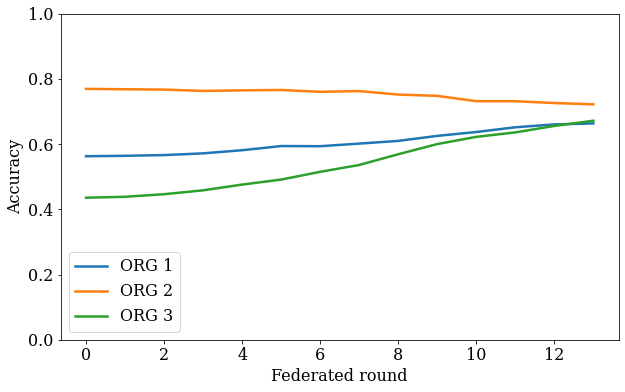

In [15]:
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

df = pd.read_csv('./results/hito3.csv')
# df["mean"] = df.mean(numeric_only=True, axis=1)
df.columns = ["ORG 1", "ORG 2", "ORG 3"]

print(f'Acc máximo: {df.mean(numeric_only=True, axis=1).max()}')

f = plt.figure(figsize=(10,6))
ax = f.add_subplot()

df.plot(ax=ax, ylim=(0,1), linewidth=2.5)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Federated round")